# ボストンデータを使い決定木分析しよう

今回は決定木を使い理解を深めることを目標にしています。

# 事前知識
決定木とは、目的変数に属する確率を複数の説明変数の組み合わせで算出する方法です。  
イメージは、Yes/Noなどの条件に属するかどうかで確率を算出します。  
「段階的にデータを分割していき、木のような分析結果を出力する」ものです。  
決定木には２種類の分析があります。  
分類木：　式１のyが、性別のように、分類可能な変数で、分類を目的にして、決定木のアルゴリズムを使用する場合  
回帰木：　不動産の家賃の変動や、株価の変動等、分類ではなく、過去、及び、現在のデータから、未来の数値を予想する場合  
これらが、目的に応じて機械学習で使用されます。  
決定木は、欠損値を欠損値として扱うこができる、特徴量のスケールの違いに影響を受けず、標準化のような前処理をしなくても良いというメリットがあり、現実的な問題に適しています。  
一方、識別規則が単純なため分散が大きく、入力データの違いによる影響を受けやすいという問題があります。 そのような欠点を解消したアルゴリズムが、ランダムフォレストです。  
またフォレストはアルゴリズム内で乱数を使っている場所が多いので，再現性がないです。

# 必要なライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# データのインポート

In [2]:
boston = load_boston()
train = pd.DataFrame(boston.data)
train.columns = boston.feature_names
train["PRICE"] = pd.DataFrame(boston.target)


まずデータをみてみましょう。  
いきなり色々なデータをプロットするのではなく一変数の可視化してデータを把握していきます。

In [3]:
train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


今回の最終目標は決定木を使いグリッドサーチを行い適切なパラメーターを見つけTARGETを予測することです。　　  
データの全体をもう少ししっかりみてみましょう


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [5]:
train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


今回のデータは欠損もなく数値データであることがわかりました。  
各データの意味をもう少し深く調べてみましょう。  
各特徴の意味は以下にまとめます。

・CRIM	人口 1 人当たりの犯罪発生数　　  
・ZN	25,000 平方フィート以上の住居区画の占める割合　　  
・INDUS	小売業以外の商業が占める面積の割合　　  
・CHAS	チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外)　　  
・NOX	NOx の濃度　　  
・RM	住居の平均部屋数　　  
・AGE	1940 年より前に建てられた物件の割合　　  
・DIS	5つのボストン市の雇用施設からの距離　　  
・RAD	環状高速道路へのアクセスしやすさ　　  
・TAX	10,000 ドルあたりの不動産税率の総計　　  
・PTRATIO	町毎の児童と教師の比率　　  
・B	町毎の黒人 (Bk) の比率を次の式で表したもの。 1000(Bk – 0.63)^2　　  
・LSTAT	給与の低い職業に従事する人口の割合　　  
・MEDV	所有者が占有している家屋のドル 1000単位の中央値　　  

このままでも学習を始めることは可能ですが、まず目的変数との相関をみてみましょう。

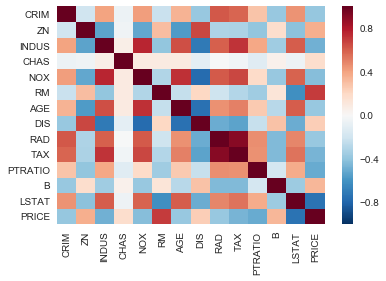

In [6]:
sns.heatmap(train.corr())

In [7]:
abs(train.corr()["PRICE"]).sort_values()[::-1]

PRICE      1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.385832
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: PRICE, dtype: float64

LSTAT と RM に強く相関が出ていることが確認できました。  
RMは住居の平均部屋数　LSTATは給与の低い職業に従事する人口の割合 (%)だそうです。  
実際にこの2つをプロットしてみてみましょう

また2つのデータを比較する際はデータの大きさを整えプロットをみやすくするため標準化や正規化を行いましょう。

In [8]:
def normalization(X):
    norma = (X - X.mean()) / X.std()
    return norma

In [9]:
train = normalization(train)

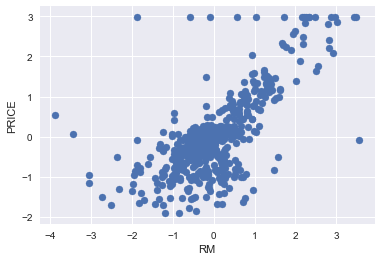

In [10]:

plt.scatter(train.RM,train.PRICE)

plt.xlabel("RM")
plt.ylabel("PRICE")
plt.show()

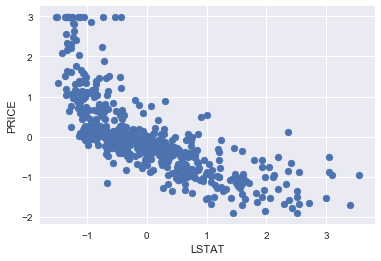

In [11]:
plt.scatter(train.LSTAT,train.PRICE)

plt.xlabel("LSTAT")
plt.ylabel("PRICE")
plt.show()

図でしてみると正の相関と負の相関がはっきりみて取れました。  
このようにはっきりと図から相関が見て取れる特徴は学習を行う上でとても重要なデータになります。  
全ての特徴を主成分分析で次元を圧縮しみてみましょう。

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=1)
pca.fit(train.drop("PRICE",axis = 1))

# 分析結果を元にデータセットを主成分に変換する
transformed = pca.fit_transform(train.drop("PRICE",axis = 1))

In [14]:
transformed

array([[-2.09576846e+00],
       [-1.45497237e+00],
       [-2.07210179e+00],
       [-2.60874995e+00],
       [-2.45554243e+00],
       [-2.21222565e+00],
       [-1.35678122e+00],
       [-8.40274525e-01],
       [-1.78564380e-01],
       [-1.07231522e+00],
       [-9.07687060e-01],
       [-1.24161534e+00],
       [-1.46080454e+00],
       [-7.34007197e-01],
       [-3.58517652e-01],
       [-7.18291360e-01],
       [-1.09893970e+00],
       [-1.49343221e-01],
       [-3.49392764e-01],
       [-3.02072094e-01],
       [ 5.28733889e-01],
       [-6.87666867e-02],
       [ 1.30305701e-01],
       [ 3.41962698e-01],
       [ 3.79626521e-02],
       [ 2.37137465e-01],
       [-4.58008568e-02],
       [ 1.81278608e-01],
       [-2.58072331e-01],
       [-3.64334829e-01],
       [ 4.80560485e-01],
       [ 1.33453246e-02],
       [ 8.31347556e-01],
       [ 3.81259332e-01],
       [ 6.45153782e-01],
       [-8.22931719e-01],
       [-7.57658735e-01],
       [-1.22495722e+00],
       [-1.2

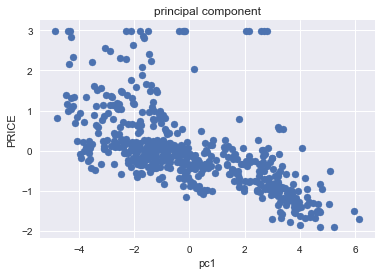

In [15]:
plt.scatter(transformed.T, train.PRICE)
plt.title('principal component')
plt.xlabel('pc1')
plt.ylabel('PRICE')

In [16]:
transformed.shape

(506, 1)

In [17]:
print(pca.explained_variance_ratio_)

[0.47097344]


LSTATに引っ張られていることがわかりました。  
次元圧縮をすることで、1度に全ての特徴をプロットすることができます。

プロットして気が付いたことがいくつかあります。  
まず部屋数ですが、とても部屋数が少なくても高い値段の付いている部屋などがあります。  
現状これが外れ値かは判断しにくいですが、学習させるモデルによっては気をつけなければなりません。

もう1つ気が付いたこととして給与の低い職業に従事する人口の割合が多いと価値が下がっていました。  
これは私の予測ですが給与の低い職業に従事する人口の割合が多いと治安が悪いのではないでしょうか？　　  
それを検証する為LSTATとCRIMを比較してみましょう。

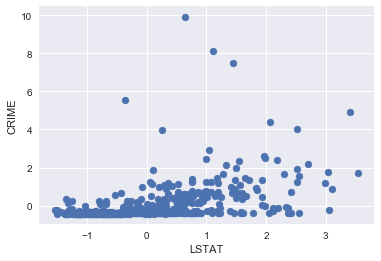

In [18]:
plt.scatter(train.LSTAT,train.CRIM)

plt.xlabel("LSTAT")
plt.ylabel("CRIME")
plt.show()

In [19]:
np.corrcoef(train.LSTAT,train.CRIM)

array([[1.        , 0.45222028],
       [0.45222028, 1.        ]])

ある程度は予想通りでしたが、そこまで関係があるとは言いにくそうです。  
１箇所とても犯罪率の高い場所がありますね。  
少し脱線してしまいますが、気になるので調べてみましょう。

In [20]:
train[train.CRIM == max(train.CRIM)]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
380,9.931906,-0.48724,1.014995,-0.272329,1.003687,0.9726,0.828634,-1.129568,1.659603,1.529413,0.805778,0.440616,0.638132,-1.319199


ZN(25,000 平方フィート以上の住居区画の占める割合)がとても狭いので、もしかしたら工場地帯かなのかもしれませんね。

これまで相関を調べてきましたが、相関係数は外れ値に大きく左右されてしまうため一概に相関係数が低くいから意味がないというわけではありません。  
その対処法として、外れ値を外すことや正規化をすることで、相関係数を正しい値にすることができます。　　  
最後に相関係数をもう1度確認してみましょう。

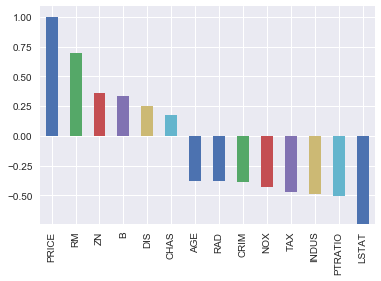

In [21]:
train.corr()["PRICE"].sort_values()[::-1].plot.bar()

今回は前処理を行う必要がないので、省略します。（実際のデータを扱う際は、前処理を行わないことはほとんどありません。）

# データセットの分割

実際のデータセットを分割して学習できる形にしましょう。

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

In [23]:
target = train["PRICE"]
train = train.drop("PRICE",axis = 1)

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train,target,test_size= 0.2,random_state=1)

# 学習

学習できる形になりました。  
実際に学習していきましょう

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

tr = DecisionTreeRegressor(random_state=10) 

tr.fit(x_train,y_train)
print('Train score: {:.3f}'.format(tr.score(x_train, y_train)))
print('Test score: {:.3f}'.format(tr.score(x_test, y_test)))


Train score: 1.000
Test score: 0.835


何もパラメーターをいじらなければ過学習してしまってますね。  
決定木はとても過学習しやすいモデルなので、グリッドサーチを行い適切なパラメーターを見つけましょう。  
下では深度だけを変えその過程をプロットしていきます。

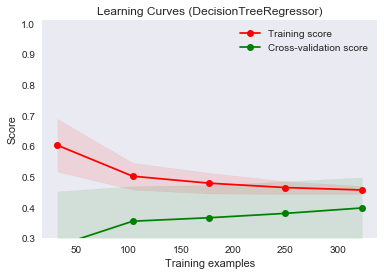

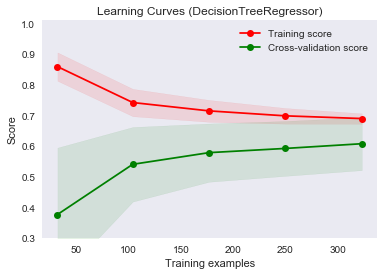

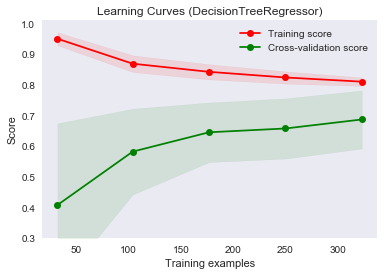

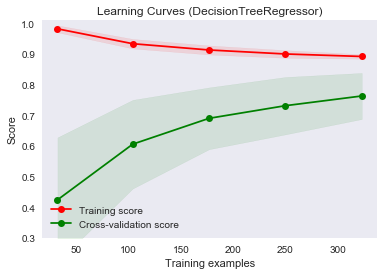

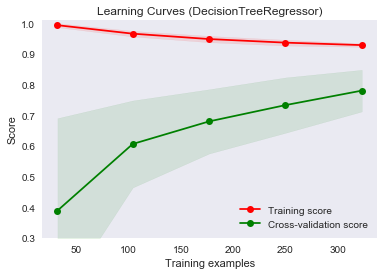

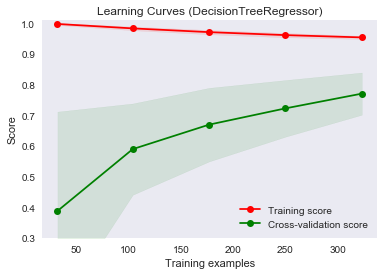

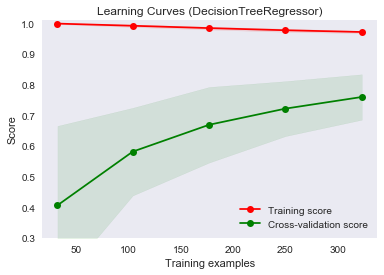

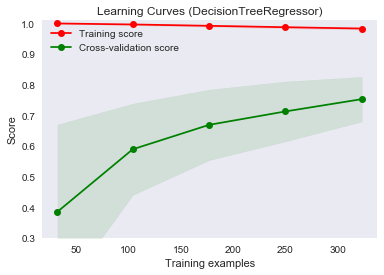

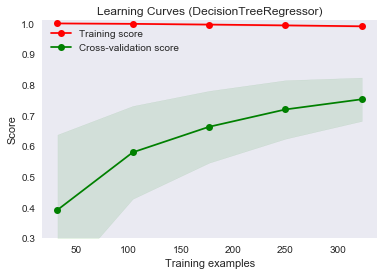

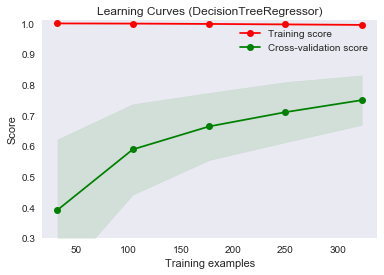

In [26]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor



title = "Learning Curves (DecisionTreeRegressor)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=1)

#平均二乗誤差をスコアとして使う場合は引数でMSEを指定してください。

for degree in range(1,11):
    estimator = DecisionTreeRegressor(max_depth=degree)
    plot_learning_curve(estimator, title,x_train , y_train, ylim=(0.3, 1.01), cv=cv, n_jobs=4)

今は深度を変えていますが、４回目や５回目（４層、５層）あたりが一番良さそうに見えます。    
決定木はとても過学習しやすいモデルなので、グリッドサーチを行い適切なパラメーターを見つけましょう。  
グリッドサーチとは、様々なパラメーターを繰り返し検証しハイパーパラメーターの探索を行うことを言います。  
他にもパラメーターを探索する方法もあり例としてランダム・サーチ RandomizedSearchCVなどが挙げられます。  
名前の通りパラメーターをランダムに決めて繰り返し試す方法です。  
これはパラメーターの予測が全く付いていない時などにパラメーターとなる候補を決めるときに使います。  
どちらを選べば良いかは、その時にある程度パラメーターの目安が決まっているかどうかで決まります。

 また上記の学習曲線はHigh variance(過学習)をおこしてしまっています。  
 上の図をみていただければ分かりますが、trainデータではほぼ予測が当たっているのでスコアが1になっていますが、別のテストデータになった場合のスコアがtrainデータと離れ過ぎています。  
 そういったデータを汎用性のないモデル、過学習を起こしているといいます。
 過学習をおこしてしまうと汎用性のないモデルになってしまうので、注意が必要です。  
 学習データではほぼ完璧に学習できていますが、同じモデルでテストデータの予測をすると０.７割くらいに落ちてしまってます。  
 
 逆に学習が足りなさすぎることをHigh Biasと言います。　　  
 深度が浅すぎると未学習状態になってしまい深すぎると過学習状態になってしまいます。  
 上の図を見ると、４、５あたりが適切な深度と言えることがわかりました。  
 
 もっと細かいパラメーターも弄る為グリッドサーチにかけましょう。

In [27]:
from sklearn.metrics import r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

regressor = DecisionTreeRegressor()
params = {"max_depth":  list(range(1,8)),"max_leaf_nodes": list(range(2,12,2))}
scoring_fnc=make_scorer(r2_score)
grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc,cv=5)
grid.fit(x_train,y_train)
print(grid.best_params_)

{'max_depth': 4, 'max_leaf_nodes': 10}


今度は平均二乗誤差を使い評価スコアを変えて見ましょう

In [28]:
regressor = DecisionTreeRegressor()
params = {"max_depth":  list(range(1,8)),"max_leaf_nodes": list(range(2,12,2))}
grid = GridSearchCV(estimator=regressor, param_grid=params, scoring="mean_squared_error",cv=5)
grid.fit(x_train,y_train)
print(grid.best_params_)

{'max_depth': 4, 'max_leaf_nodes': 10}


ほとんど同じスコアになりましたね！

上で出てきている数字が適切な深度と葉の数の上限です。  
今度はこれを使い学習して見ましょう。

In [29]:
rf = DecisionTreeRegressor(max_depth = 5,max_leaf_nodes = 10)
rf.fit(x_train,y_train)
print('Train score: {:.3f}'.format(rf.score(x_train, y_train)))
print('Test score: {:.3f}'.format(rf.score(x_test, y_test)))

Train score: 0.874
Test score: 0.850


今度はトレインデータとテストデータの差がかなり小さくなりました。  
これは適切なパラメーターである証になります。  
このように適切なパラメーターを見つけることが汎用性の高いモデルを作ることに大切になります。  
その過程もプロットしてみましょう。

In [30]:
pred = rf.predict(x_test)

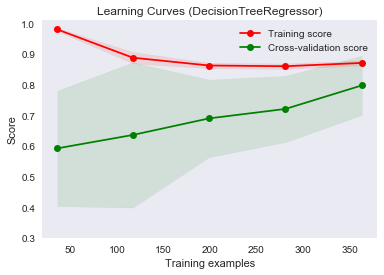

In [31]:
plot_learning_curve(rf, title,x_train , y_train, ylim=(0.3, 1.01), cv=10, n_jobs=5)

かなり学習データとテストデータで近い結果が出せていることがわかりました。  
また目標としている0.850を出すことができました。  
これで葉の数と深度が適切であることがわかりました。

最後に決定木がどの特徴をどのように分けたか見て理解を深めていきましょう。

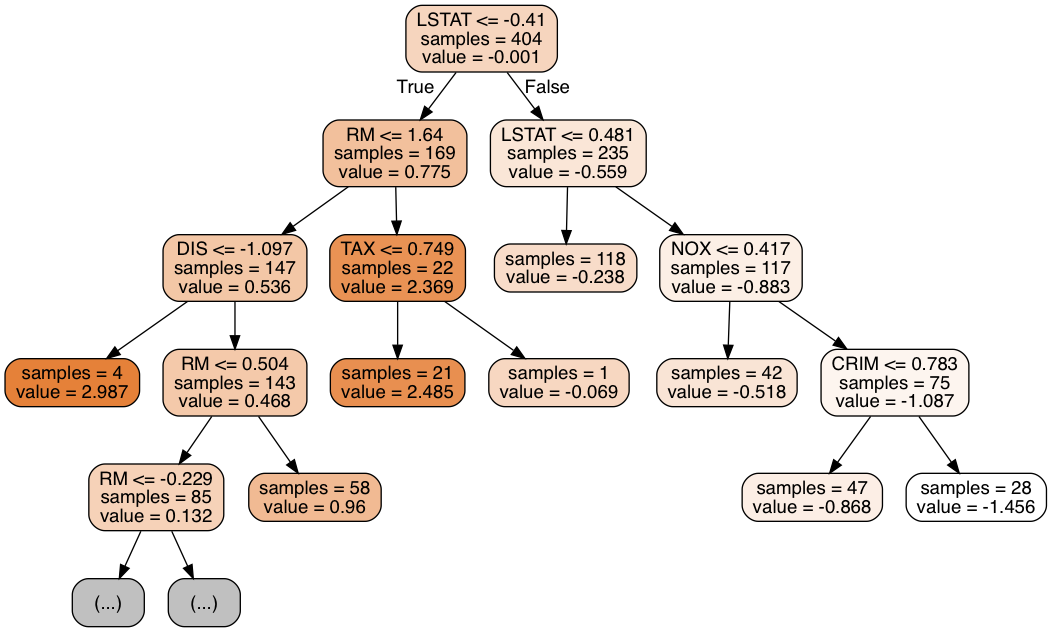

In [32]:
#sklearn.treeは決定木分析ができる
from sklearn import tree

#Pythonの表示ツール用の公開API
from IPython.display import Image as PImage

#サブプロセス管理
from subprocess import check_call

#Pillowは画像処理ライブラリ
from PIL import Image, ImageDraw, ImageFont

#正規表現ライブラリ
import re

# 訓練されたモデルを.dotファイルとしてエクスポートする
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(rf,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,#各ノードに不純物を表示します。
                              feature_names = x_train.columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,#ツリーをトップダウンでなく左から右に向けます。
                              filled= True )#分類のための多数決クラス、回帰の値の末尾数、
        #または複数出力のノードの純度を示すノードをペイントします。
        
#.dotを.pngに変換してWebノートブックに表示できるようにする
#check_callでコマンドでファイル検索
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# PILによるチャートの注釈
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

やはりLSTATとRMを最初に持ってきて分析を行なっていました。  
相関係数から最初に発見した予測が合っていました。  
決定木がどのような特徴を重要だとしてるかプロットしてみます。

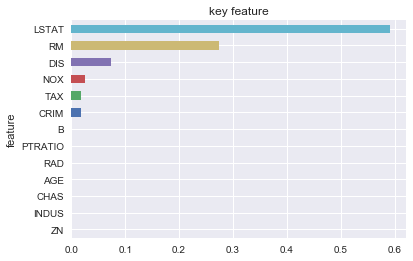

In [33]:
fi = pd.DataFrame({'feature': list(x_train.columns), 'importance': rf.feature_importances_})
fi = fi.sort_values(by = "importance")[::-1]
name = fi["feature"]
value = fi["importance"]
value.index = name

value[:20][::-1].plot.barh()
plt.title("key feature")
plt.show()

やはりLSTATが一番重要な特徴だということがここでも明らかになりました。  
以上でこのカーネルは終わりになります。

今回の課題での発見は同じ特徴で学習しても決定木の分岐が変わり同じモデルにならないことがあるというのはとても勉強になりました。  